# Ions in a Penning trap

Penning traps are an important experimental tool for confining charged particles. They are used to collect elementary particles produced in high energy experiments, to increase the efficiency of vacuum pumps, and to trap cold ions for quantum simulation and quantum metrology experiments. In this notebook we discuss how the dynamics of charged particles in Penning traps can be simulated using the cold-atoms library.

Perhaps the most essential component of a Penning trap is a strong nearly homogeneous magnetic field which we will assume to be pointing in the positive $z$ direction. The Lorentz force due to the magnetic field bends the motion of charged particles (for instance ions or electrons) into circular orbits. If the particle motion is damped e.g. via laser cooling confinement results. Motion along the magnetic fields is confined via electrostatic potentials. With laser cooled ensembles of ions it is in fact possible to achieve phase space densities so high that the balance of confinement and repulsive Coulomb forces produces crystals.

We will see that our conventional drift-kick integration is inadequate for the motion of charged particles in strong magnetic fields. We will discuss an alternative integration scheme that is stable and accurate. We will investigate the convergence of this integrator and we will show the steady state that emerges when the different forces in the system balance each other.

In [65]:
import coldatoms
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from IPython import display

We consider a configuration of ions that is typical for the single plane experiments with Beryllium in the ion storage group at NIST, Boulder. We load the initial configuration from a data file:

In [89]:
input_configuration = np.loadtxt('inputIonConfiguration.dat')

This is a matrix the rows corresponding to x, y, z, vx, vy, vz, charge, and mass. For example, the first particle has the following state:

In [90]:
input_configuration[:,0]

array([  1.00799552e-05,  -9.47328408e-06,  -9.52882956e-44,
         2.61945844e+00,   2.78756571e+00,   2.38067112e-37,
         1.60217660e-19,   1.49674940e-26])

Now we need to convert this input a coldatoms ensemble:

In [68]:
def create_ensemble(configuration):
    ensemble = coldatoms.Ensemble(configuration.shape[1])
    ensemble.x = np.ascontiguousarray(np.transpose(configuration[0:3, :]))
    ensemble.v = np.ascontiguousarray(np.transpose(configuration[3:6, :]))
    ensemble.ensemble_properties['charge'] = configuration[6, 0]
    ensemble.ensemble_properties['mass'] = configuration[7, 0]
    return ensemble

Here is a top view of the ion crystal:

<IPython.core.display.Javascript object>


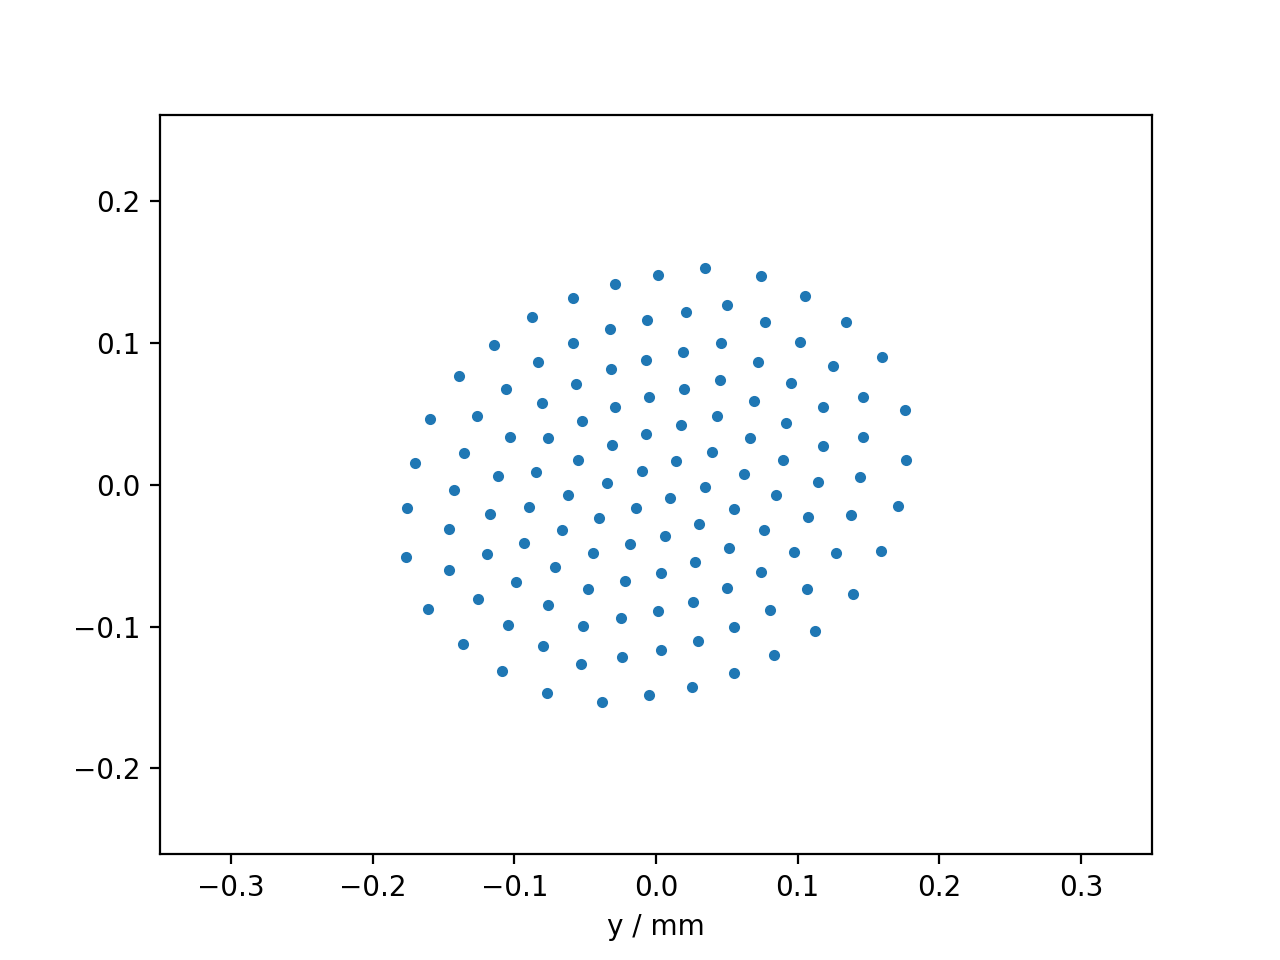

In [95]:
ensemble = create_ensemble(input_configuration)
plt.figure()
plt.plot(1.0e3 * ensemble.x[:, 0], 1.0e3 * ensemble.x[:, 1], 'o', ms=3);
x_max = 3.5e-1
y_max = x_max
plt.xlim([-x_max, x_max])
plt.ylim([-y_max, y_max])
plt.axes().set_aspect('equal', 'datalim')
plt.xlabel('x / mm')
plt.xlabel('y / mm');

The ions are arranged in a single plane of a crystal with approximately triangular symmetry. The crystal is elliptical because of the so called rotating wall potential. This potential co-rotates with the ions and ensures that the ions rotate with a controlled frequency which is needed for confinement in the Penning trap. The rotating wall potential perturbs the symmetry of the crystal especially near the edges. Also, the spacing between the ions increases towards the edges of the crystal.

The strongest forces in our system are the Coulomb force and the Lorentz force due to the axial magnetic fields in the Penning trap. We have already encountered the Coulomb force provided by the coldatoms library in other notebooks so we'll just use that here:

In [74]:
coulomb_force = coldatoms.CoulombForce()

The magnetic field has some pecularities and we'll discuss it in a bit more detail next.


## Axial Penning trap field

On the face of it the Lorentz force induced by the axial magnetic field is straight forward. It is simply a force which we can supply to our drift-kick integrator. However, it turns out that the accuracy of the drift-kick integrator is only first order and the integrator is no longer symplectic. Fundamentally this is because the Lorentz force is velocity dependent. Thus our forces now contain both momentum and position dependent terms. The simple momentum kick implemented in the drift kick integrator is no longer an exact integration of the force terms. Hence the loss of accuracy and stability.

To see this computationally we can represent the Lorentz force due to the axial magnetic field by the following class:

In [75]:
class AxialLorentzForce(object):
    """Lorentz force due to axial magnetic field in Penning trap."""
    
    def __init__(self, b_field):
        self.b_field = b_field
        
    def force(self, dt, ensemble, f):
        q = ensemble.ensemble_properties['charge']
        if q is None:
            q = ensemble.particle_properties['charge']
            if q is None:
                raise RuntimeError('Must provide ensemble or per particle charge')
            
        f += dt * self.b_field * np.column_stack(
            (q * ensemble.v[:, 1], -q * ensemble.v[:, 0], np.zeros_like(ensemble.x[:, 0])))

The old Penning trap in the ion storage group at NIST had a field strenght of 4.458 Tesla:

In [96]:
lorentz_force = AxialLorentzForce(4.458)

With no other forces acting on the particle we expect it to execute cyclotron motion. In the x-y plance the particle ought to move on a circle. Integreting the motion of a single ion now using the drift-kick integrator we find the following:

The expected gyro radius is:
2.09555297581e-07


<IPython.core.display.Javascript object>


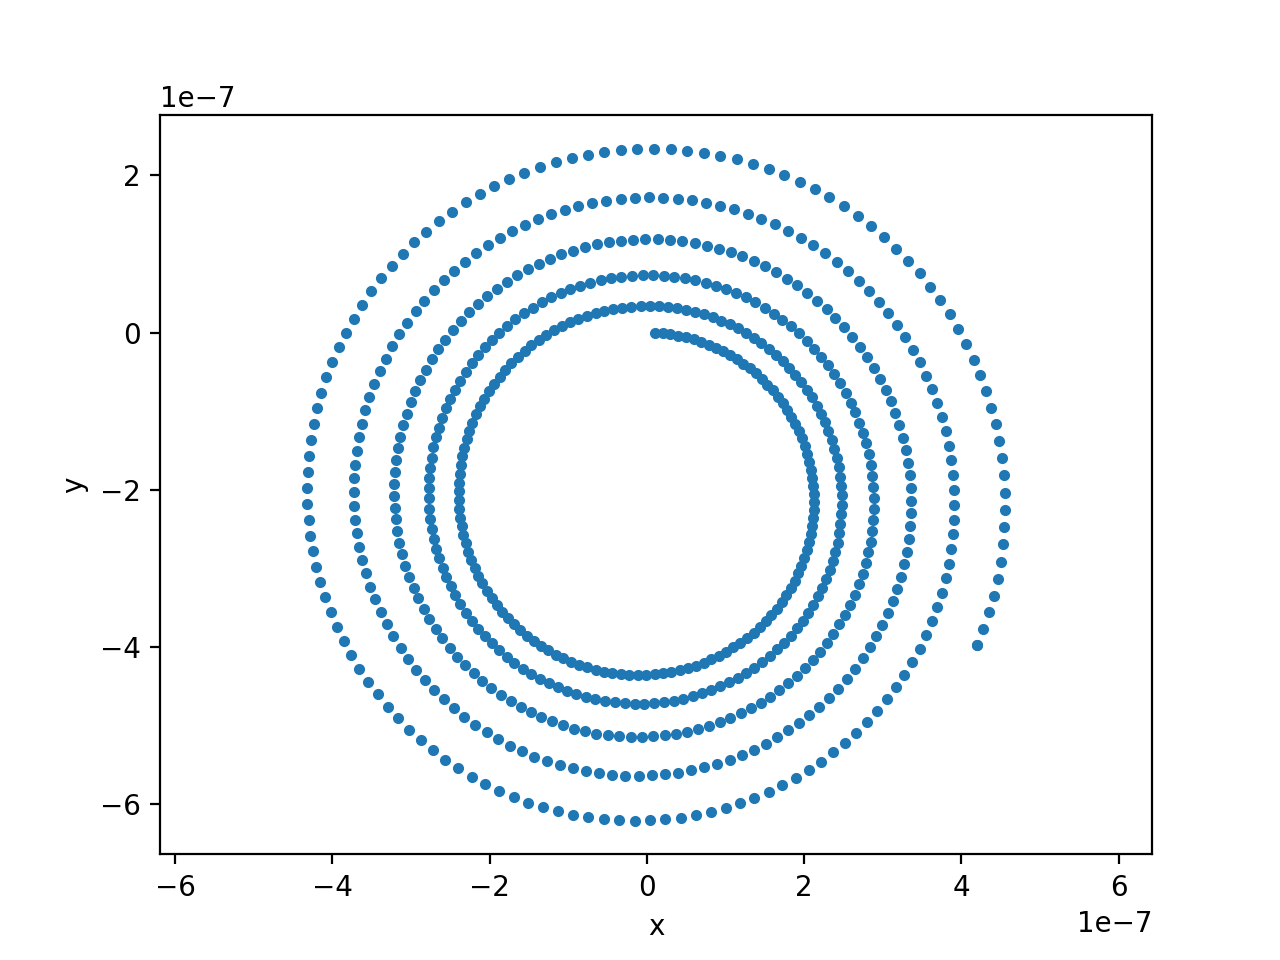

In [97]:
m = ensemble.ensemble_properties['mass']
q = ensemble.ensemble_properties['charge']
B = lorentz_force.b_field
v = 10.0 # m/s
print('The expected gyro radius is:')
print(m * v / (q * B))

test_ensemble = coldatoms.Ensemble(1)
test_ensemble.v[0, 0] = v
test_ensemble.ensemble_properties['mass'] = m
test_ensemble.ensemble_properties['charge'] = q

f = np.zeros_like(test_ensemble.v)
lorentz_force.force(1.0e-9, test_ensemble, f)

positions = [test_ensemble.x[0]]
dt = 1.0e-9
for i in range(700):
    coldatoms.drift_kick(dt, test_ensemble, [lorentz_force])
    positions.append(np.copy(test_ensemble.x[0]))

positions = np.array(positions)
plt.figure()
plt.plot(positions[:, 0], positions[:, 1], 'o', ms=3);
plt.xlabel('x')
plt.ylabel('y')
plt.axes().set_aspect('equal', 'datalim')

The ion initially moves on a circular trajectory in agreement with the theoretical prediction. By and by its speed increases as is evident by the increasing spacing between successive positions. As the speed increases the cyclotron radius increases and the ion spirals further and further away from the guiding center.

There are several well documented and researched integrators that do not suffer from these accuracy issues and which maintain symplecticity. Perhaps the most well known is the so called Boris advance. However, for our purposes it is not a great fit because we need to combine the electromagnetic forces with several other forces some of which are not conservative such as the radiation pressure force with its damping and fluctuating components. Furthermore, some of the other forces are position dependent while others are momentum dependent, ruining the very special structure needed for the Boris update.

Instead we use a different splitting of the particle dynamics where we combine the magnetic force with the kinetic energy. The free evolution in the constant magnetic field is the already mentioned cyclotron motion which we can integrate exactly. This alternative integration scheme is sometimes referred to as a bend-kick integrator, alluding to the fact that the free particle motion is along bent trajectories. In the coldatoms library this integrator is implemented in the bend_kick function.

The following figure shows the motion of 10 particles with the same velocity. We see that the particles move along perfectly circular orbits.

<IPython.core.display.Javascript object>


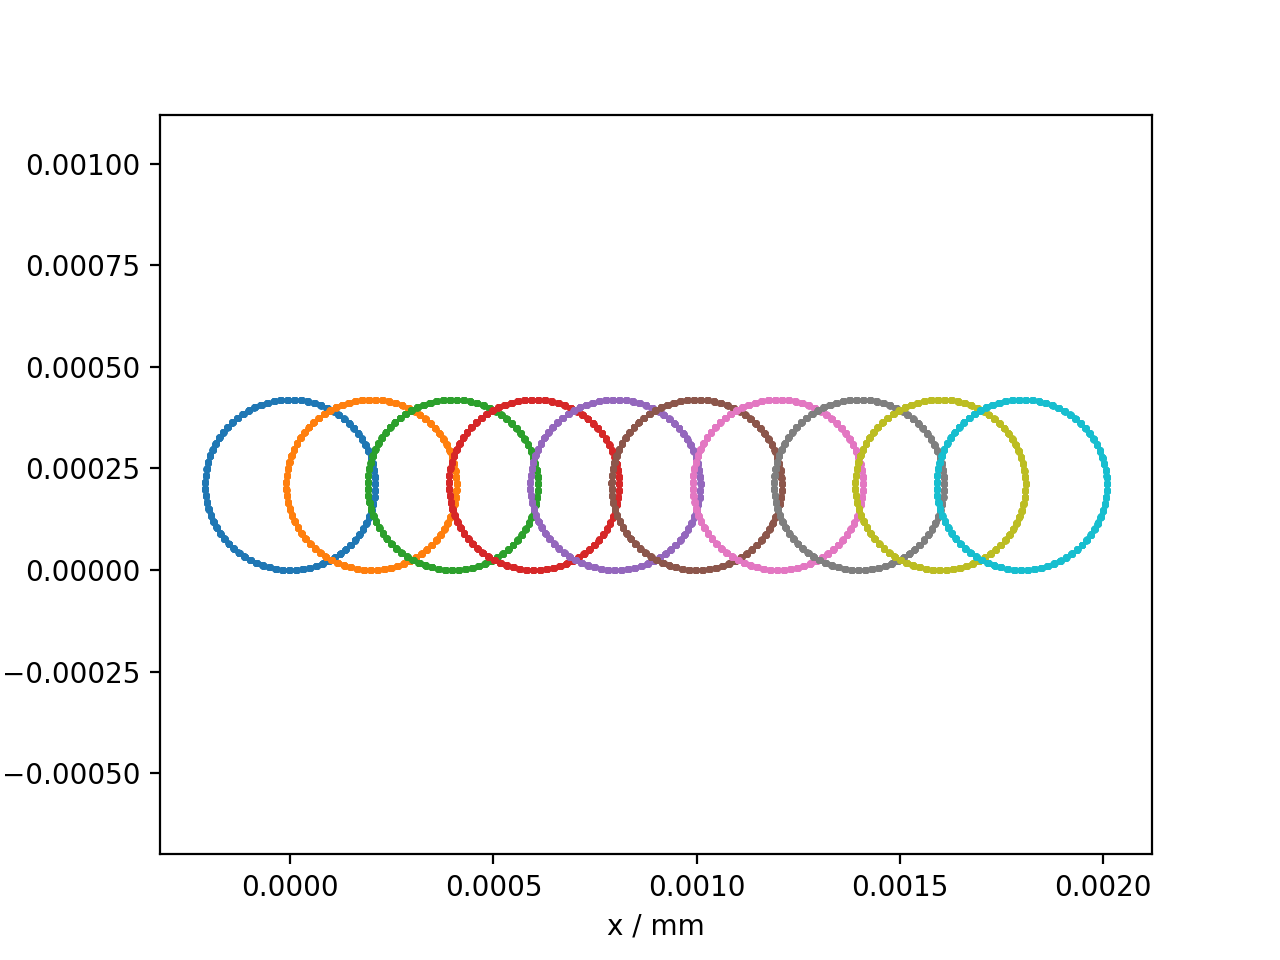

In [99]:
m = ensemble.ensemble_properties['mass']
q = ensemble.ensemble_properties['charge']
B = lorentz_force.b_field
v = 10.0 # m/s

test_ensemble = coldatoms.Ensemble(10)
test_ensemble.v[:, 0] = v
for i in range(test_ensemble.num_ptcls):
    test_ensemble.x[i, 0] = 2.0e-7 * i
test_ensemble.ensemble_properties['mass'] = m
test_ensemble.ensemble_properties['charge'] = q

positions = [test_ensemble.x]
dt = 1.0e-7
for i in range(600):
    coldatoms.bend_kick(dt, B, test_ensemble, [])
    positions.append(np.copy(test_ensemble.x))

positions = np.array(positions)
plt.figure()
for i in range(test_ensemble.num_ptcls):
    plt.plot(1.0e3 * positions[:, i, 0], 1.0e3 * positions[:, i, 1], '.', ms=3);
plt.xlabel('x / mm')
plt.ylabel('y / mm')
plt.axes().set_aspect('equal', 'datalim')

## Trap potential

As mentioned the axial magnetic field gives rise to confinement of the particle motion in the $x-y$ plane. To prevent the particles from escaping along the $z$ axis (i.e. along the magnetic field lines) experimentalists use electrostatic potentials. For example, for positively charged ions, positiviely charge end caps induce a restoring force that drives the ions back to the $z=0$ plane. Note that the end-cap potential induces a de-confining force along $x$ and $y$. We have to ensure that this force is smaller than the confinement due to the axial magnetic field.

The trap potential can be represented by the following force:

In [81]:
class TrapPotential(object):

    def __init__(self, kz, delta, omega, phi_0):
        self.kz = kz
        self.kx = -(0.5 + delta) * kz
        self.ky = -(0.5 - delta) * kz
        self.phi_0 = phi_0
        self.phi = phi_0
        self.omega = omega

    def reset_phase(self):
        self.phi = self.phi_0
            
    def force(self, dt, ensemble, f):
        self.phi += self.omega * 0.5 * dt
        
        q = ensemble.ensemble_properties['charge']
        if q is None:
            q = ensemble.particle_properties['charge']
            if q is None:
                raise RuntimeError('Must provide ensemble or per particle charge')

        cphi = np.cos(self.phi)
        sphi = np.sin(self.phi)
        kx = self.kx
        ky = self.ky
        
        x = ensemble.x[:, 0]
        y = ensemble.x[:, 1]
        z = ensemble.x[:, 2]
        
        f[:, 0] += dt * q * (
            (-kx * cphi * cphi - ky * sphi * sphi) * x + cphi * sphi * (ky - kx) * y)
        f[:, 1] += dt * q * (
            cphi * sphi * (ky - kx) * x + (-kx * sphi * sphi - ky * cphi * cphi) * y)
        f[:, 2] += -dt * q *self.kz * z

        self.phi += self.omega * 0.5 * dt

The trap at NIST has the following configuration:

In [171]:
phi0=0.42
trap_potential = TrapPotential(1.167e6, 0.0036, 2.0 * np.pi * 44.0e3, phi0)

# Convergence

First we investigate the error as a function of the time step size to figure out how small of a time step size we need to choose to achieve reasonable accuracy. An evolution of an ensemble of ions can be evaluated using the following function:

In [172]:
def evolve_ensemble(dt, t_max, ensemble, Bz, forces):
    t = 0.0e0
    while t < t_max - dt:
        coldatoms.bend_kick(dt, Bz, ensemble, forces)
        t += dt
    coldatoms.bend_kick(t_max - t, Bz, ensemble, forces)

The following figure shows a top view of the initial ion distribution and the ion distribution after $10 \mu s$. During this time the ions undergo several full revolutions in the trap. We see that the overall size of the cloud does not change significantly owing to the numerical stability of the bend-kick integrator.

<IPython.core.display.Javascript object>


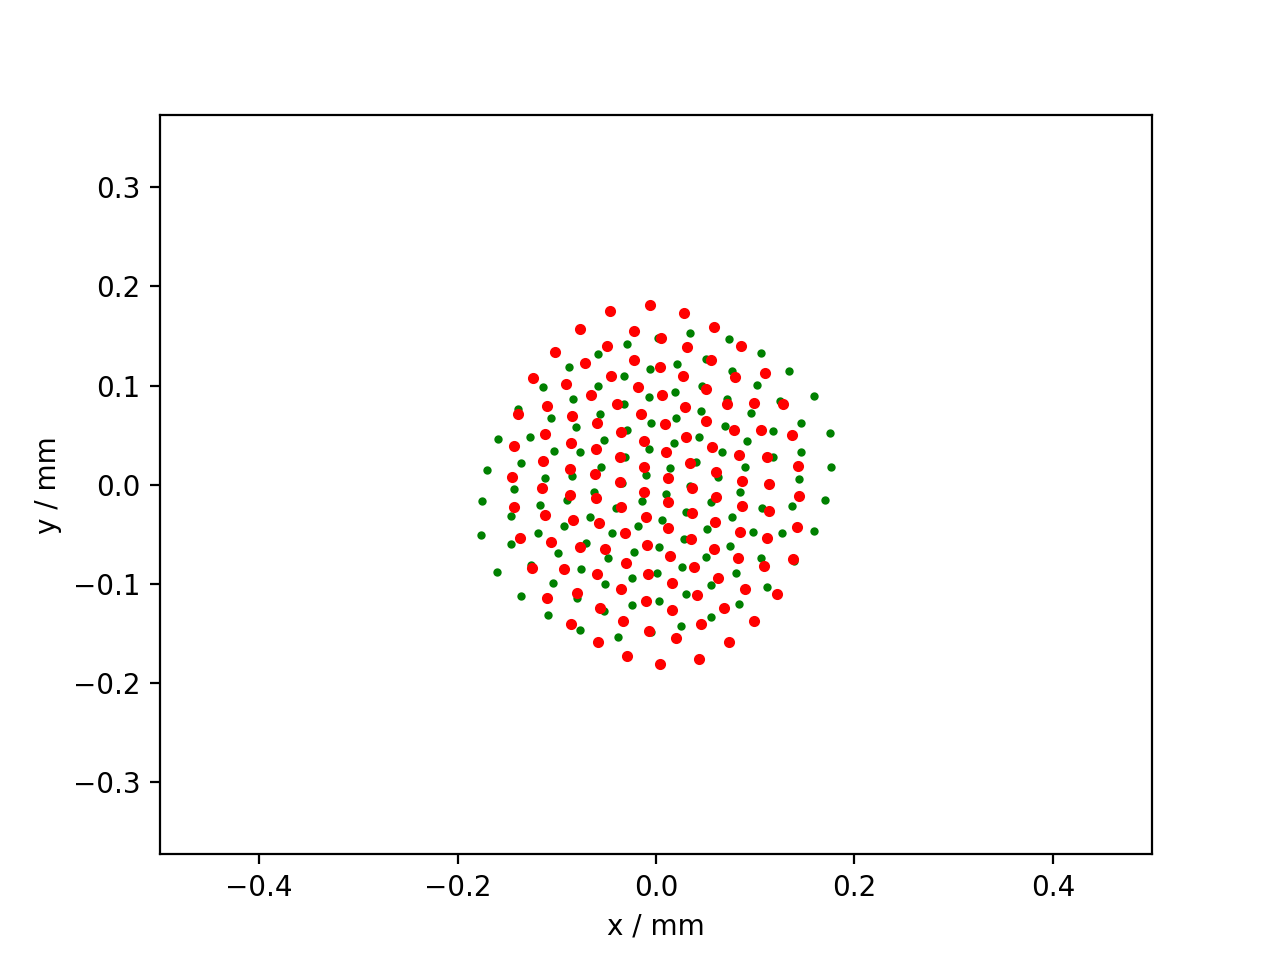

In [173]:
my_ensemble = create_ensemble(input_configuration)

Bz = 4.458

evolve_ensemble(1.0e-9, 1.0e-5, my_ensemble, Bz, [coulomb_force, trap_potential])

plt.figure()
plt.plot(1.0e3 * ensemble.x[:,0], 1.0e3 * ensemble.x[:,1], 'go', ms=2);
plt.plot(1.0e3 * my_ensemble.x[:,0], 1.0e3 * my_ensemble.x[:,1], 'ro', ms=3)
plt.xlabel('x / mm')
plt.ylabel('y / mm')
x_max = 0.5e0
y_max = x_max
plt.xlim([-x_max, x_max])
plt.ylim([-y_max, y_max])
plt.axes().set_aspect('equal', 'datalim')

To evaluate the convergence of the integrator we use a reference solution obtained with a time step size of $1{\rm ns}$. During this time the ions travel approximately $10^{-2}$ inter ion spacings:

In [174]:
trap_potential.phi = phi0
reference_solution = create_ensemble(input_configuration)
evolve_ensemble(1.0e-9, 1.0e-5, reference_solution, Bz, [coulomb_force, trap_potential])

We then compute the error for a given $dt$ as the $L_2$ distance of the ions' positions from the reference solution:

In [175]:
def mean_error(x, y):
    n = x.shape[0]
    assert(n == y.shape[0])
    assert(x.shape[1] == y.shape[1])
    error = 0.0
    for i in range(n):
        error += np.linalg.norm(x[i] - y[i])**2
    error /= n
    error = np.sqrt(error)
    return error
        
def compute_error(dt, reference_solution):
    trap_potential.phi = phi0
    my_ensemble = create_ensemble(input_configuration)
    evolve_ensemble(dt, 1.0e-5, my_ensemble, Bz, [coulomb_force, trap_potential])
    return mean_error(my_ensemble.x, reference_solution.x)

In [186]:
dt_min = 5.0e-9
dt_max = 1.0e-4
num_pts = 60
ddt = (dt_max / dt_min) ** (1.0 / (num_pts - 1.0))
dts = [dt_min * ddt**e for e in range(num_pts)]
errors = [compute_error(dt, reference_solution) for dt in dts]

The following figure illustrates the convergence of the integrator from a time step size of $5{\rm ns}$ to $0.1{\rm ms}$. The figure shows the mean error of the particle positions after a total integration time of $10^{-5}{\rm s}$. The orange line is a quadratic for orientation. From a time step size of approximately $0.1\mu{\rm s}$ on the integrator converges approximately quadratically. For larger time steps the error exhibits complicated behavior, presumably because the time step size is in resonance with various acoustic excitations in the system. The error never exceeds about $10^{-4}{\rm m}$, the overall size of the crystal.

<IPython.core.display.Javascript object>


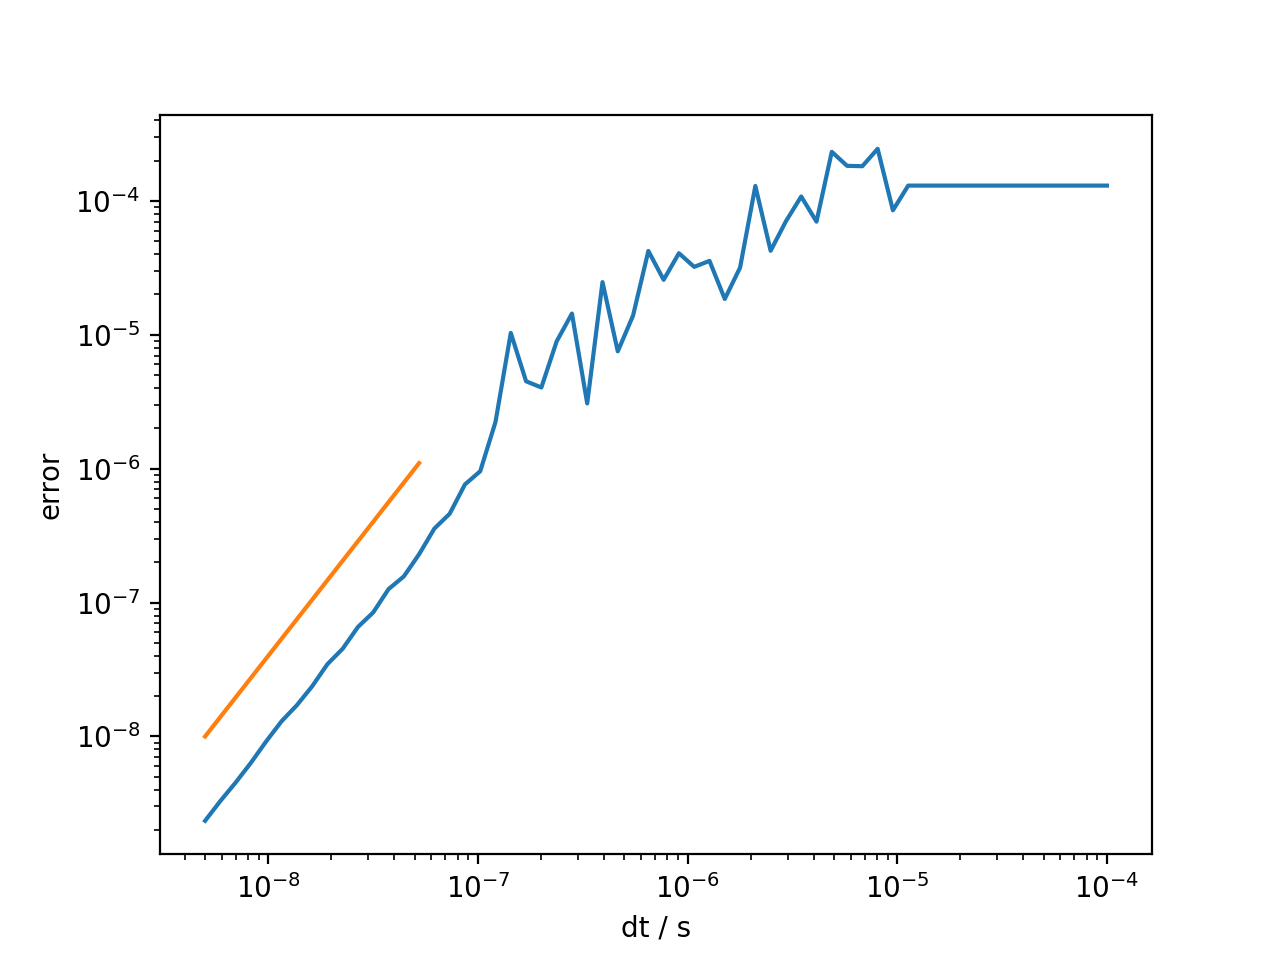

In [196]:
plt.figure()
plt.loglog(dts, errors);
plt.loglog(np.array(dts)[:15], (np.array(dts)[:15] / 5.0e-5)**2);
plt.xlabel('dt / s')
plt.ylabel('error')

# Evolution with artificial damping

The rest of this notebook gathers a few hacks that are useful for manipulating ions in Penning traps and in particular for finding low energy states. To get the system to settle to a low energy state we need to dampen the ions' motion.

The first two classes allow us to dampen the angular motion and the in-plane motion. This damping forces are unphysical in the sense that they do not introduce fluctuations that go along with the damping force. They correspond to zero-temperature damping.

In [197]:
class AngularDamping(object):

    def __init__(self, omega, kappa_theta):
        self.omega = omega
        self.kappa_theta = kappa_theta
            
    def dampen(self, dt, ensemble):
        x = ensemble.x[:, 0]
        y = ensemble.x[:, 1]
        z = ensemble.x[:, 2]
        vx = ensemble.v[:, 0]
        vy = ensemble.v[:, 1]
        vz = ensemble.v[:, 2]
        
        expMinusKappaDt = np.exp(-self.kappa_theta * dt)
        
        for i in range(ensemble.num_ptcls):
            r = np.sqrt(x[i] * x[i] + y[i] * y[i])
            v = np.array([vx[i], vy[i]])
            v_hat = np.array([-y[i], x[i]]) / r
            v_par = v_hat.dot(v) * v_hat
            v_perp = v - v_par
            v_target = self.omega * r * v_hat
            
            v_updated = v_perp + v_target + (v_par - v_target) * expMinusKappaDt
            ensemble.v[i, 0] = v_updated[0]
            ensemble.v[i, 1] = v_updated[1]

In [198]:
class SimplisticOpticalMolasses(object):

    def __init__(self, kappa, sigma):
        self.kappa = kappa
        self.sigma = sigma
            
    def dampen(self, dt, ensemble):
        vx = ensemble.v[:, 0]
        y = ensemble.x[:, 1]

        damping_factor = np.exp(-self.kappa * dt)
        intensity = np.exp(-(y**2) / (self.sigma**2))
        
        ensemble.vx = (1.0 - intensity) * vx + intensity * damping_factor * vx

In [199]:
def evolve_ensemble_with_damping(dt, t_max, ensemble, Bz, forces, dampings):
    t = 0
    while t < t_max:
        coldatoms.bend_kick(dt, Bz, ensemble, forces)
        for damping in dampings:
            damping.dampen(dt, ensemble)
        t += dt

In [208]:
my_angular_damping = AngularDamping(trap_potential.omega, 1.0e7)
my_optical_molasses = SimplisticOpticalMolasses(1.0e7, 2.0e-4)

The following functions allow us to match the rotational velocity of the ions to that of the rotating wall and to expand the cloud to a larger size. The latter can be useful to reduce the Coulomb repulsing of the ions.

In [209]:
def spin_up(ensemble, omega):
    radii = np.sqrt(ensemble.x[:, 0]**2 + ensemble.x[:, 1]**2)
    velocities = omega * radii
    for i in range(ensemble.num_ptcls):
        v = np.array([-ensemble.x[i, 1], ensemble.x[i, 0]])
        v = v / np.linalg.norm(v)
        v = velocities[i] * v
        ensemble.v[i, 0] = v[0]
        ensemble.v[i, 1] = v[1]

In [210]:
def expand_cloud(ensemble, expansion_factor):
    ensemble.x *= expansion_factor

Here we quickly demonstrate how to use all these things in conjunction with one another.

<IPython.core.display.Javascript object>


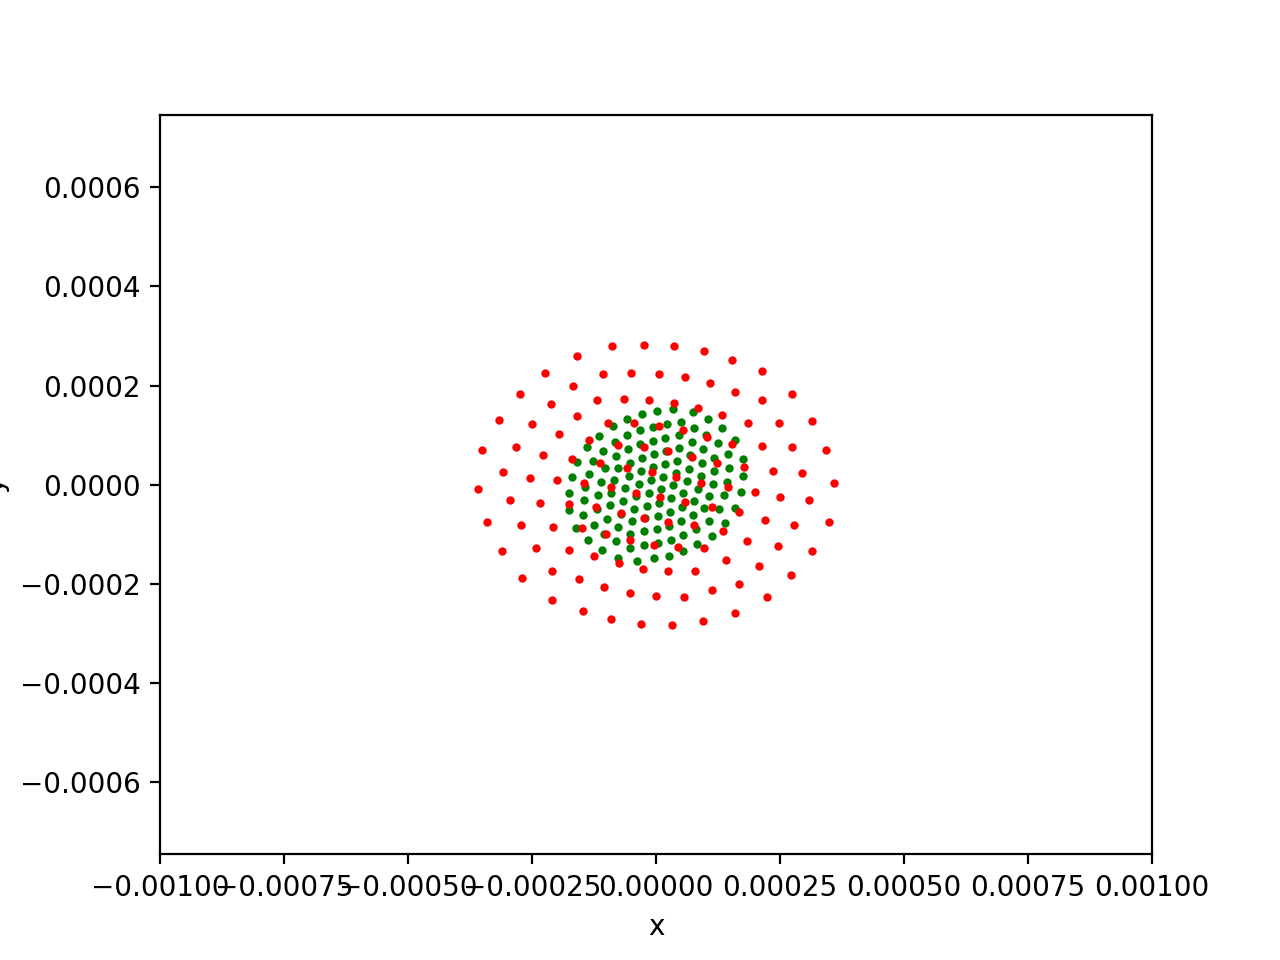

In [215]:
Omega = 2.0 * np.pi * 44.0e3
my_ensemble = create_ensemble(input_configuration)
t = 0.0
expand_cloud(my_ensemble, 2.0)
spin_up(my_ensemble, Omega)

trap_potential = TrapPotential(2.0 * 1.167e6, 0.0036, 2.0 * np.pi * 44.0e3, 0.42)
Bz = 4.458

plt.figure()

delta_t = 1.0e-5
dt = 1.0e-8

evolve_ensemble_with_damping(dt, delta_t, my_ensemble, Bz,
                       [coulomb_force, trap_potential], [my_optical_molasses, my_angular_damping])
t += delta_t

plt.plot(ensemble.x[:,0], ensemble.x[:,1], 'go', ms=2);
plt.plot(my_ensemble.x[:,0], my_ensemble.x[:,1], 'ro', ms=2)
plt.xlabel('x')
plt.ylabel('y')
x_max = 1.0e-3
y_max = x_max
plt.xlim([-x_max, x_max])
plt.ylim([-y_max, y_max])
plt.axes().set_aspect('equal', 'datalim')